In [ ]:
# ============================================
# STEP 1: Install Required Libraries
# ============================================
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
import warnings
import zipfile
import os
from tqdm import tqdm
from collections import defaultdict
warnings.filterwarnings('ignore')

print("✅ Libraries installed and imported successfully!\n")

✅ Libraries installed and imported successfully!



In [ ]:
# ============================================
# STEP 2: Download MIND Small Dataset
# ============================================
print("📥 Downloading MIND Small Dataset...")

# Download training data
!wget -q https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip -O MINDsmall_train.zip
# Download validation data
!wget -q https://mind201910small.blob.core.windows.net/release/MINDsmall_dev.zip -O MINDsmall_dev.zip



📥 Downloading MIND Small Dataset...


In [ ]:
import zipfile
import os
import shutil

def extract_and_flatten(zip_path, target_dir):
    """
    Extracts a ZIP file, detects if the contents are wrapped in a single
    root folder (e.g., 'MINDsmall_dev/'), and moves the contents directly
    into the specified target_dir, avoiding nested folders.
    """

    if not os.path.exists(zip_path):
        print(f"⚠️ Warning: ZIP file not found: {zip_path}")
        return

    # Create a temporary extraction directory
    temp_dir = f"temp_{target_dir}"
    os.makedirs(temp_dir, exist_ok=True)

    print(f"📦 Extracting {zip_path} to temporary folder...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the root folder inside the temporary directory
    extracted_contents = os.listdir(temp_dir)
    source_root = temp_dir

    # If there is exactly one folder inside temp_dir, that's the one we need to flatten
    if len(extracted_contents) == 1 and os.path.isdir(os.path.join(temp_dir, extracted_contents[0])):
        source_root = os.path.join(temp_dir, extracted_contents[0])

    # Ensure the final target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Move all files/folders from the source root to the final target directory
    print(f"⬆️ Flattening structure: Moving contents from {source_root} to {target_dir}")
    for item in os.listdir(source_root):
        shutil.move(os.path.join(source_root, item), target_dir)

    # Clean up the temporary directory
    shutil.rmtree(temp_dir)
    print(f"✅ Successfully extracted and flattened {zip_path} into {target_dir}")

# =========================================================================
# MODIFIED EXTRACTION LOGIC
# =========================================================================

# The code will now create:
# - 'MINDsmall_train/' containing 'news.tsv', 'behaviors.tsv', etc.
# - 'MINDsmall_dev/' containing 'news.tsv', 'behaviors.tsv', etc.

extract_and_flatten('MINDsmall_train.zip', 'MINDsmall_train')
extract_and_flatten('MINDsmall_dev.zip', 'MINDsmall_dev')

print("\n✅ Dataset extracted and flattened!\n")

📦 Extracting MINDsmall_train.zip to temporary folder...
⬆️ Flattening structure: Moving contents from temp_MINDsmall_train/MINDsmall_train to MINDsmall_train
✅ Successfully extracted and flattened MINDsmall_train.zip into MINDsmall_train
📦 Extracting MINDsmall_dev.zip to temporary folder...
⬆️ Flattening structure: Moving contents from temp_MINDsmall_dev/MINDsmall_dev to MINDsmall_dev
✅ Successfully extracted and flattened MINDsmall_dev.zip into MINDsmall_dev

✅ Dataset extracted and flattened!



In [ ]:
# ============================================
# STEP 3: Load and Parse News Data
# ============================================
print("📰 Loading news articles...")

def load_news(file_path):
    """Load news.tsv file"""
    columns = ['news_id', 'category', 'subcategory', 'title', 'abstract',
               'url', 'title_entities', 'abstract_entities']

    news_df = pd.read_csv(file_path, sep='\t', names=columns, header=None)

    # Fill missing values
    news_df['abstract'] = news_df['abstract'].fillna('')
    news_df['title'] = news_df['title'].fillna('')

    # Combine title and abstract for content
    news_df['content'] = news_df['title'] + ' ' + news_df['abstract']

    return news_df

# Load training news
train_news = load_news('MINDsmall_train/news.tsv')
print(f"✅ Training news loaded: {len(train_news)} articles")

# Load validation news
dev_news = load_news('MINDsmall_dev/news.tsv')
print(f"✅ Validation news loaded: {len(dev_news)} articles")

# Combine all news for comprehensive model
all_news = pd.concat([train_news, dev_news]).drop_duplicates(subset='news_id').reset_index(drop=True)
print(f"✅ Total unique articles: {len(all_news)}\n")

# Display sample
print("📄 Sample articles:")
print(all_news[['news_id', 'category', 'title']].head())
print()

📰 Loading news articles...
✅ Training news loaded: 51282 articles
✅ Validation news loaded: 42416 articles
✅ Total unique articles: 65238

📄 Sample articles:
  news_id   category                                              title
0  N55528  lifestyle  The Brands Queen Elizabeth, Prince Charles, an...
1  N19639     health                      50 Worst Habits For Belly Fat
2  N61837       news  The Cost of Trump's Aid Freeze in the Trenches...
3  N53526     health  I Was An NBA Wife. Here's How It Affected My M...
4  N38324     health  How to Get Rid of Skin Tags, According to a De...



In [ ]:
# ============================================
# STEP 4: Load User Behaviors
# ============================================
print("👥 Loading user behaviors...")

def load_behaviors(file_path):
    """Load behaviors.tsv file"""
    columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']

    behaviors_df = pd.read_csv(file_path, sep='\t', names=columns, header=None)

    # Parse history (clicked news)
    behaviors_df['history'] = behaviors_df['history'].fillna('').apply(lambda x: x.split())

    # Parse impressions (news shown with click label)
    behaviors_df['impressions'] = behaviors_df['impressions'].apply(lambda x: x.split())

    return behaviors_df

# Load training behaviors
train_behaviors = load_behaviors('MINDsmall_train/behaviors.tsv')
print(f"✅ Training behaviors loaded: {len(train_behaviors)} records")
print(f"   Unique users: {train_behaviors['user_id'].nunique()}")

# Load validation behaviors
dev_behaviors = load_behaviors('MINDsmall_dev/behaviors.tsv')
print(f"✅ Validation behaviors loaded: {len(dev_behaviors)} records")
print(f"   Unique users: {dev_behaviors['user_id'].nunique()}\n")

# Display sample
print("📊 Sample user behavior:")
print(train_behaviors[['user_id', 'history', 'impressions']].head(2))
print()

👥 Loading user behaviors...
✅ Training behaviors loaded: 156965 records
   Unique users: 50000
✅ Validation behaviors loaded: 73152 records
   Unique users: 50000

📊 Sample user behavior:
  user_id                                            history  \
0  U13740  [N55189, N42782, N34694, N45794, N18445, N6330...   
1  U91836  [N31739, N6072, N63045, N23979, N35656, N43353...   

                                         impressions  
0                               [N55689-1, N35729-0]  
1  [N20678-0, N39317-0, N58114-0, N20495-0, N4297...  



In [ ]:
# ============================================
# STEP 5: Data Preprocessing
# ============================================
print("🔧 Preprocessing data...")

# Create news_id to index mapping
news_id_to_idx = {news_id: idx for idx, news_id in enumerate(all_news['news_id'])}
idx_to_news_id = {idx: news_id for news_id, idx in news_id_to_idx.items()}

# Build user history dictionary
def build_user_history(behaviors_df):
    """Build user reading history"""
    user_history = {}
    for _, row in behaviors_df.iterrows():
        user_id = row['user_id']
        history = row['history']

        # Filter valid news IDs
        valid_history = [nid for nid in history if nid in news_id_to_idx]

        if user_id not in user_history:
            user_history[user_id] = []
        user_history[user_id].extend(valid_history)

    # Remove duplicates
    for user_id in user_history:
        user_history[user_id] = list(set(user_history[user_id]))

    return user_history

train_user_history = build_user_history(train_behaviors)
dev_user_history = build_user_history(dev_behaviors)

print(f"✅ User histories built:")
print(f"   Training users: {len(train_user_history)}")
print(f"   Validation users: {len(dev_user_history)}\n")

🔧 Preprocessing data...
✅ User histories built:
   Training users: 50000
   Validation users: 50000



In [ ]:
# ============================================
# STEP 6: Feature Extraction with TF-IDF
# ============================================
print("🔍 Extracting TF-IDF features...")

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Fit and transform on all news content
tfidf_matrix = tfidf.fit_transform(all_news['content'])
print(f"✅ TF-IDF matrix shape: {tfidf_matrix.shape}")

# Instead of computing full similarity matrix (which crashes),
# we optimize by creating a function that computes similarity only when needed

from sklearn.metrics.pairwise import cosine_similarity

def get_similar_articles(article_index, tfidf_matrix, top_k=10):
    """
    Compute top-K similar articles for a single article
    without creating the full NxN similarity matrix.
    """
    sims = cosine_similarity(
        tfidf_matrix[article_index],
        tfidf_matrix
    ).flatten()

    similar_idx = sims.argsort()[::-1][1:top_k+1]
    return similar_idx

print("⚡ Optimized similarity computation ready (no huge matrix created)\n")


🔍 Extracting TF-IDF features...
✅ TF-IDF matrix shape: (65238, 5000)
⚡ Optimized similarity computation ready (no huge matrix created)



In [ ]:
# ============================================
# STEP 7: Build Recommendation Functions (Optimized & Fixed)
# ============================================
print("🎯 Building optimized recommendation engine...")

def get_user_profile_optimized(history, tfidf_matrix, news_id_to_idx):
    """Create user profile from reading history (optimized)"""
    if not history:
        return None

    # Get indices of read articles
    indices = [news_id_to_idx[nid] for nid in history if nid in news_id_to_idx]

    if not indices:
        return None

    # Average TF-IDF vectors of read articles - FIX: convert to array
    user_profile = np.asarray(tfidf_matrix[indices].mean(axis=0))

    return user_profile

def recommend_for_user_optimized(user_history, tfidf_matrix, news_id_to_idx,
                                 idx_to_news_id, top_n=10, exclude_read=True):
    """Generate recommendations for a user (optimized)"""

    # Get user profile
    user_profile = get_user_profile_optimized(user_history, tfidf_matrix, news_id_to_idx)

    if user_profile is None:
        return []

    # FIX: Reshape user profile for cosine_similarity
    user_profile = user_profile.reshape(1, -1)

    # Compute similarity with all articles at once
    similarities = cosine_similarity(user_profile, tfidf_matrix).flatten()

    # Get top similar articles
    similar_indices = similarities.argsort()[::-1]

    recommendations = []
    read_news_ids = set(user_history) if exclude_read else set()

    for idx in similar_indices:
        news_id = idx_to_news_id[idx]

        if news_id not in read_news_ids:
            recommendations.append(news_id)

            if len(recommendations) >= top_n:
                break

    return recommendations

print("✅ Optimized recommendation engine ready!\n")

🎯 Building optimized recommendation engine...
✅ Optimized recommendation engine ready!



In [ ]:
# ============================================
# STEP 8: Generate Recommendations (Optimized)
# ============================================
print("💡 Generating recommendations for sample users...")

# Test on validation users
sample_users = list(dev_user_history.keys())[:5]

for i, user_id in enumerate(sample_users, 1):
    print(f"\n{'='*70}")
    print(f"USER {i}: {user_id}")
    print(f"{'='*70}")

    history = dev_user_history[user_id]
    print(f"📖 Read {len(history)} articles")

    # Show some read articles
    if history:
        print("\n🔹 Sample read articles:")
        sample_read = history[:3]
        for nid in sample_read:
            if nid in all_news['news_id'].values:
                article = all_news[all_news['news_id'] == nid].iloc[0]
                print(f"   • [{article['category']}] {article['title'][:60]}...")

    # Get recommendations using optimized function
    recommendations = recommend_for_user_optimized(
        history, tfidf_matrix, news_id_to_idx, idx_to_news_id, top_n=5
    )

    print(f"\n💡 Top 5 Recommendations:")
    for j, nid in enumerate(recommendations, 1):
        if nid in all_news['news_id'].values:
            article = all_news[all_news['news_id'] == nid].iloc[0]
            print(f"   {j}. [{article['category']}] {article['title'][:60]}...")

print(f"\n{'='*70}\n")

💡 Generating recommendations for sample users...

USER 1: U80234
📖 Read 15 articles

🔹 Sample read articles:
   • [lifestyle] Queen Elizabeth Finally Had Her Dream Photoshoot, Thanks to ...
   • [news] Felicity Huffman Smiles as She Begins Community Service Foll...
   • [news] Hundreds of thousands of people in California are downriver ...

💡 Top 5 Recommendations:
   1. [news] At least one missing, two dead in New Orleans Hard Rock Hote...
   2. [news] Hard Rock Hotel: Demolition blasts one crane near French Qua...
   3. [news] Mayor vows 'relentless' investigation in deadly Hard Rock Ho...
   4. [news] Video purports to show flaws inside Hard Rock Hotel before c...
   5. [news] Watch: Cranes collapse in controlled explosion over Hard Roc...

USER 2: U60458
📖 Read 13 articles

🔹 Sample read articles:
   • [finance] Amazon makes grocery delivery free for Prime members...
   • [finance] Apple is laying the groundwork for an iPhone subscription...
   • [lifestyle] A part of Windsor Castl

In [ ]:
# ============================================
# STEP 9: Comprehensive Evaluation Metrics
# ============================================
print("📈 Evaluating model performance with comprehensive metrics...")

from sklearn.metrics import precision_score, recall_score, f1_score

def parse_impressions(impressions_list):
    """Parse impressions into news_id and label"""
    impressions = []
    for imp in impressions_list:
        parts = imp.split('-')
        if len(parts) == 2:
            news_id, label = parts
            impressions.append((news_id, int(label)))
    return impressions

def evaluate_model_comprehensive(behaviors_df, user_history, tfidf_matrix,
                                 news_id_to_idx, idx_to_news_id, k_values=[5, 10]):
    """Comprehensive evaluation with Precision, Recall, AUC, MRR, NDCG"""

    all_aucs = []
    all_mrrs = []
    precision_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    ndcg_at_k = {k: [] for k in k_values}

    print("Evaluating on validation set (500 samples)...")

    for idx, row in tqdm(behaviors_df.head(500).iterrows(), total=500):
        user_id = row['user_id']

        if user_id not in user_history:
            continue

        history = user_history[user_id]
        impressions = parse_impressions(row['impressions'])

        if not impressions or len(impressions) < 2:
            continue

        # Get user profile
        user_profile = get_user_profile_optimized(history, tfidf_matrix, news_id_to_idx)

        if user_profile is None:
            continue

        user_profile = user_profile.reshape(1, -1)

        scores = []
        labels = []
        news_ids = []

        for news_id, label in impressions:
            if news_id in news_id_to_idx:
                idx_news = news_id_to_idx[news_id]
                score = cosine_similarity(user_profile, tfidf_matrix[idx_news]).flatten()[0]
                scores.append(score)
                labels.append(label)
                news_ids.append(news_id)

        if len(set(labels)) < 2 or len(scores) == 0:
            continue

        # Calculate AUC
        try:
            auc = roc_auc_score(labels, scores)
            all_aucs.append(auc)
        except:
            pass

        # Calculate MRR
        sorted_indices = np.argsort(scores)[::-1]
        for rank, idx in enumerate(sorted_indices, 1):
            if labels[idx] == 1:
                all_mrrs.append(1.0 / rank)
                break

        # Calculate Precision@K and Recall@K
        for k in k_values:
            top_k_indices = sorted_indices[:k]
            top_k_labels = [labels[i] for i in top_k_indices]

            # Precision@K
            if len(top_k_labels) > 0:
                precision = sum(top_k_labels) / len(top_k_labels)
                precision_at_k[k].append(precision)

            # Recall@K
            total_relevant = sum(labels)
            if total_relevant > 0:
                recall = sum(top_k_labels) / total_relevant
                recall_at_k[k].append(recall)

            # NDCG@K
            dcg = sum([labels[i] / np.log2(rank + 2) for rank, i in enumerate(top_k_indices)])
            idcg = sum([1.0 / np.log2(rank + 2) for rank in range(min(k, total_relevant))])
            if idcg > 0:
                ndcg_at_k[k].append(dcg / idcg)

    # Compile results
    results = {
        'AUC': np.mean(all_aucs) if all_aucs else 0,
        'MRR': np.mean(all_mrrs) if all_mrrs else 0,
    }

    for k in k_values:
        results[f'Precision@{k}'] = np.mean(precision_at_k[k]) if precision_at_k[k] else 0
        results[f'Recall@{k}'] = np.mean(recall_at_k[k]) if recall_at_k[k] else 0
        results[f'NDCG@{k}'] = np.mean(ndcg_at_k[k]) if ndcg_at_k[k] else 0

    return results, {
        'aucs': all_aucs,
        'mrrs': all_mrrs,
        'precision': precision_at_k,
        'recall': recall_at_k,
        'ndcg': ndcg_at_k
    }

# Evaluate model
results, detailed_metrics = evaluate_model_comprehensive(
    dev_behaviors, dev_user_history, tfidf_matrix,
    news_id_to_idx, idx_to_news_id, k_values=[5, 10, 20]
)

print("\n" + "="*70)
print("📊 COMPREHENSIVE MODEL PERFORMANCE")
print("="*70)
print(f"AUC Score:        {results['AUC']:.4f}")
print(f"MRR Score:        {results['MRR']:.4f}")
print("-" * 70)
print(f"Precision@5:      {results['Precision@5']:.4f}")
print(f"Recall@5:         {results['Recall@5']:.4f}")
print(f"NDCG@5:           {results['NDCG@5']:.4f}")
print("-" * 70)
print(f"Precision@10:     {results['Precision@10']:.4f}")
print(f"Recall@10:        {results['Recall@10']:.4f}")
print(f"NDCG@10:          {results['NDCG@10']:.4f}")
print("-" * 70)
print(f"Precision@20:     {results['Precision@20']:.4f}")
print(f"Recall@20:        {results['Recall@20']:.4f}")
print(f"NDCG@20:          {results['NDCG@20']:.4f}")
print("="*70)

📈 Evaluating model performance with comprehensive metrics...
Evaluating on validation set (500 samples)...


100%|██████████| 500/500 [00:15<00:00, 33.20it/s]


📊 COMPREHENSIVE MODEL PERFORMANCE
AUC Score:        0.5797
MRR Score:        0.3237
----------------------------------------------------------------------
Precision@5:      0.1261
Recall@5:         0.4287
NDCG@5:           0.3036
----------------------------------------------------------------------
Precision@10:     0.1134
Recall@10:        0.6037
NDCG@10:          0.3644
----------------------------------------------------------------------
Precision@20:     0.1062
Recall@20:        0.7496
NDCG@20:          0.4048



📊 Creating comprehensive visualizations...


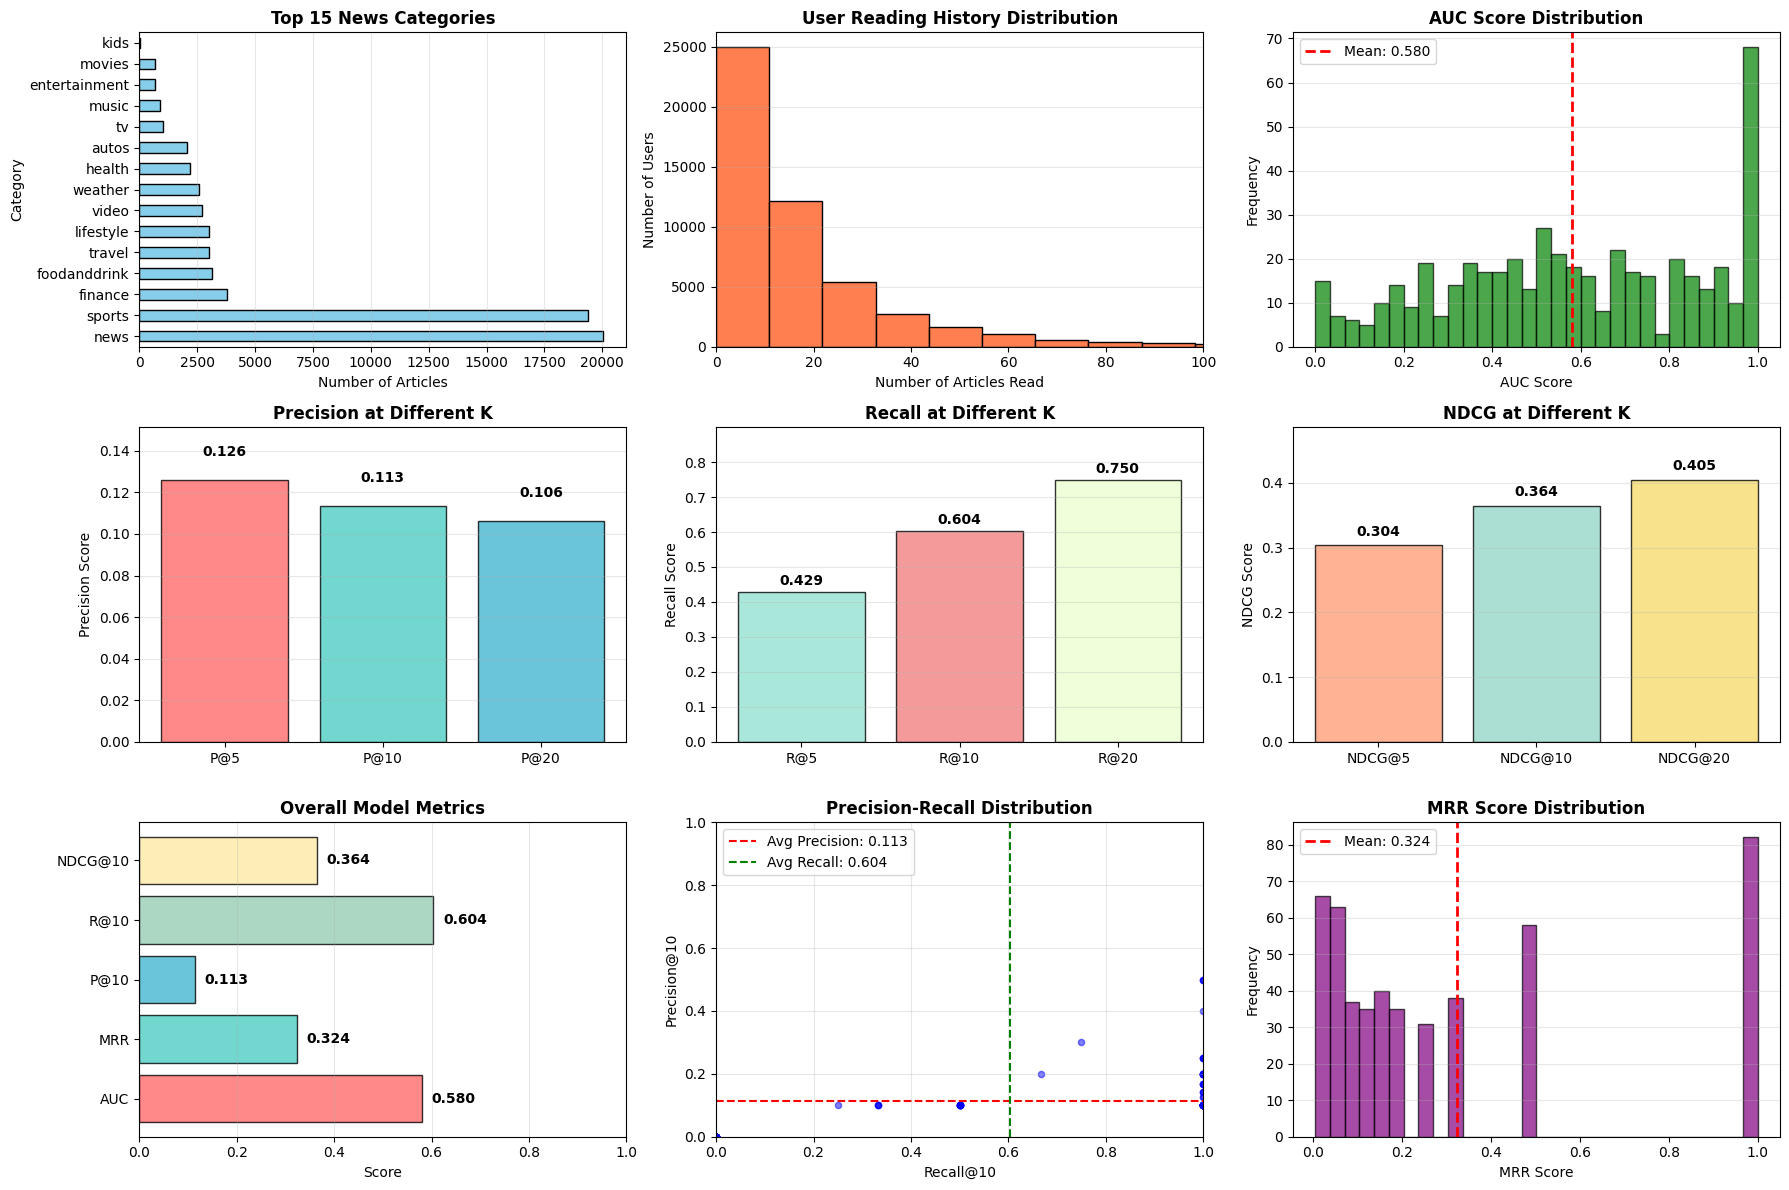

✅ Comprehensive visualizations saved as 'mind_comprehensive_evaluation.png'



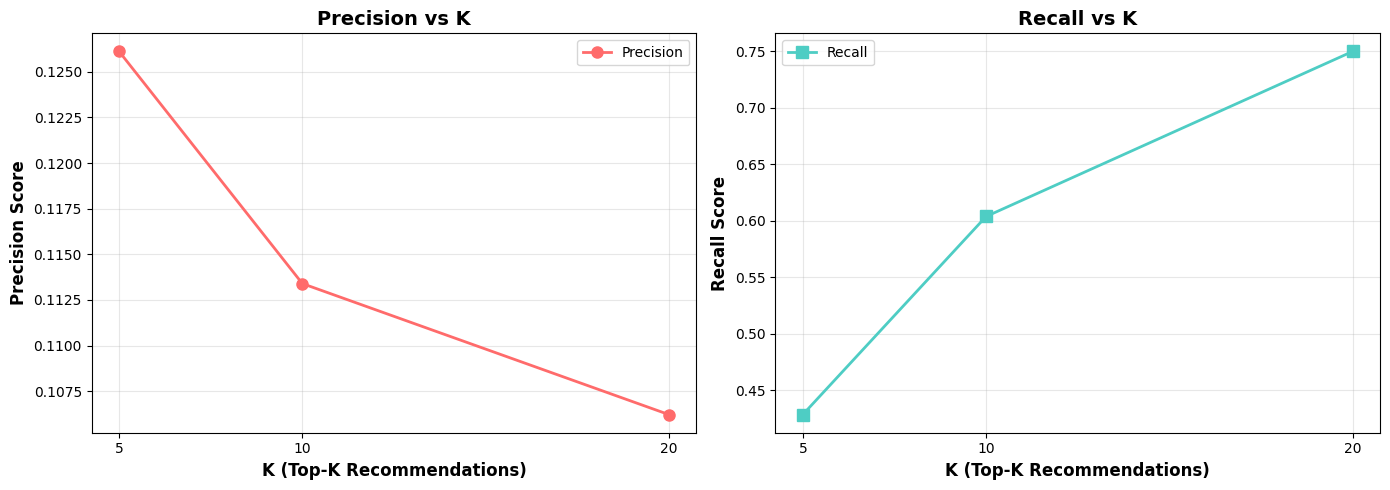

✅ Precision-Recall curves saved as 'precision_recall_vs_k.png'



In [ ]:
# ============================================
# STEP 10: Comprehensive Visualizations
# ============================================
print("\n📊 Creating comprehensive visualizations...")

# Check if detailed_metrics exists, if not create empty structure
if 'detailed_metrics' not in locals():
    print("⚠️ Running evaluation to generate detailed metrics...")
    results, detailed_metrics = evaluate_model_comprehensive(
        dev_behaviors, dev_user_history, tfidf_matrix,
        news_id_to_idx, idx_to_news_id, k_values=[5, 10, 20]
    )
    print("✅ Evaluation complete!")

fig = plt.figure(figsize=(18, 12))

# 1. Category Distribution
plt.subplot(3, 3, 1)
category_counts = all_news['category'].value_counts().head(15)
category_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 15 News Categories', fontsize=12, fontweight='bold')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.grid(axis='x', alpha=0.3)

# 2. User Reading History Distribution
plt.subplot(3, 3, 2)
history_lengths = [len(hist) for hist in train_user_history.values()]
plt.hist(history_lengths, bins=50, color='coral', edgecolor='black')
plt.title('User Reading History Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Articles Read')
plt.ylabel('Number of Users')
plt.xlim(0, min(100, max(history_lengths)))
plt.grid(axis='y', alpha=0.3)

# 3. AUC Distribution
plt.subplot(3, 3, 3)
if detailed_metrics['aucs']:
    plt.hist(detailed_metrics['aucs'], bins=30, color='green', edgecolor='black', alpha=0.7)
    plt.axvline(results['AUC'], color='red', linestyle='--', linewidth=2, label=f'Mean: {results["AUC"]:.3f}')
    plt.title('AUC Score Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('AUC Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No AUC data available', ha='center', va='center', fontsize=12)
    plt.title('AUC Score Distribution', fontsize=12, fontweight='bold')

# 4. Precision at Different K
plt.subplot(3, 3, 4)
k_values = [5, 10, 20]
precisions = [results[f'Precision@{k}'] for k in k_values]
plt.bar(range(len(k_values)), precisions, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
        edgecolor='black', alpha=0.8)
plt.xticks(range(len(k_values)), [f'P@{k}' for k in k_values])
plt.title('Precision at Different K', fontsize=12, fontweight='bold')
plt.ylabel('Precision Score')
plt.ylim(0, max(precisions) * 1.2 if max(precisions) > 0 else 1)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Recall at Different K
plt.subplot(3, 3, 5)
recalls = [results[f'Recall@{k}'] for k in k_values]
plt.bar(range(len(k_values)), recalls, color=['#95E1D3', '#F38181', '#EAFFD0'],
        edgecolor='black', alpha=0.8)
plt.xticks(range(len(k_values)), [f'R@{k}' for k in k_values])
plt.title('Recall at Different K', fontsize=12, fontweight='bold')
plt.ylabel('Recall Score')
plt.ylim(0, max(recalls) * 1.2 if max(recalls) > 0 else 1)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. NDCG at Different K
plt.subplot(3, 3, 6)
ndcgs = [results[f'NDCG@{k}'] for k in k_values]
plt.bar(range(len(k_values)), ndcgs, color=['#FFA07A', '#98D8C8', '#F7DC6F'],
        edgecolor='black', alpha=0.8)
plt.xticks(range(len(k_values)), [f'NDCG@{k}' for k in k_values])
plt.title('NDCG at Different K', fontsize=12, fontweight='bold')
plt.ylabel('NDCG Score')
plt.ylim(0, max(ndcgs) * 1.2 if max(ndcgs) > 0 else 1)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(ndcgs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. Overall Metrics Comparison
plt.subplot(3, 3, 7)
metrics_names = ['AUC', 'MRR', 'P@10', 'R@10', 'NDCG@10']
metrics_values = [
    results['AUC'],
    results['MRR'],
    results['Precision@10'],
    results['Recall@10'],
    results['NDCG@10']
]
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
plt.barh(metrics_names, metrics_values, color=colors_palette, edgecolor='black', alpha=0.8)
plt.title('Overall Model Metrics', fontsize=12, fontweight='bold')
plt.xlabel('Score')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_values):
    plt.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

# 8. Precision-Recall Curve at K=10
plt.subplot(3, 3, 8)
if detailed_metrics['precision'][10] and detailed_metrics['recall'][10]:
    precision_vals = detailed_metrics['precision'][10]
    recall_vals = detailed_metrics['recall'][10]

    # Limit points for better visualization
    sample_size = min(100, len(precision_vals))
    plt.scatter(recall_vals[:sample_size], precision_vals[:sample_size],
                alpha=0.5, c='blue', s=20)
    plt.plot([0, 1], [results['Precision@10'], results['Precision@10']],
             'r--', label=f'Avg Precision: {results["Precision@10"]:.3f}')
    plt.plot([results['Recall@10'], results['Recall@10']], [0, 1],
             'g--', label=f'Avg Recall: {results["Recall@10"]:.3f}')
    plt.xlabel('Recall@10')
    plt.ylabel('Precision@10')
    plt.title('Precision-Recall Distribution', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
else:
    plt.text(0.5, 0.5, 'No P-R data available', ha='center', va='center', fontsize=12)
    plt.title('Precision-Recall Distribution', fontsize=12, fontweight='bold')

# 9. MRR Distribution
plt.subplot(3, 3, 9)
if detailed_metrics['mrrs']:
    plt.hist(detailed_metrics['mrrs'], bins=30, color='purple', edgecolor='black', alpha=0.7)
    plt.axvline(results['MRR'], color='red', linestyle='--', linewidth=2,
                label=f'Mean: {results["MRR"]:.3f}')
    plt.title('MRR Score Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('MRR Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No MRR data available', ha='center', va='center', fontsize=12)
    plt.title('MRR Score Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('mind_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualizations saved as 'mind_comprehensive_evaluation.png'\n")

# Additional: Precision-Recall Trade-off Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Precision vs K
ax[0].plot(k_values, precisions, marker='o', linewidth=2, markersize=8,
           color='#FF6B6B', label='Precision')
ax[0].set_xlabel('K (Top-K Recommendations)', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Precision Score', fontsize=12, fontweight='bold')
ax[0].set_title('Precision vs K', fontsize=14, fontweight='bold')
ax[0].grid(True, alpha=0.3)
ax[0].legend()
ax[0].set_xticks(k_values)

# Recall vs K
ax[1].plot(k_values, recalls, marker='s', linewidth=2, markersize=8,
           color='#4ECDC4', label='Recall')
ax[1].set_xlabel('K (Top-K Recommendations)', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Recall Score', fontsize=12, fontweight='bold')
ax[1].set_title('Recall vs K', fontsize=14, fontweight='bold')
ax[1].grid(True, alpha=0.3)
ax[1].legend()
ax[1].set_xticks(k_values)

plt.tight_layout()
plt.savefig('precision_recall_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Precision-Recall curves saved as 'precision_recall_vs_k.png'\n")

In [ ]:
# ============================================
# STEP 11: Production-Ready Class with Metrics
# ============================================

class MINDNewsRecommender:
    """Production-ready news recommender with comprehensive metrics"""

    def __init__(self, news_df, tfidf_matrix, news_id_to_idx, idx_to_news_id):
        self.news_df = news_df
        self.tfidf_matrix = tfidf_matrix
        self.news_id_to_idx = news_id_to_idx
        self.idx_to_news_id = idx_to_news_id
        self.performance_metrics = results

    def recommend(self, user_history, top_n=10, return_scores=False):
        """Get recommendations for user with optional scores"""

        if not user_history:
            return [] if not return_scores else ([], [])

        # Get user profile
        user_profile = get_user_profile_optimized(user_history, self.tfidf_matrix,
                                                   self.news_id_to_idx)

        if user_profile is None:
            return [] if not return_scores else ([], [])

        user_profile = user_profile.reshape(1, -1)

        # Compute similarity with all articles
        similarities = cosine_similarity(user_profile, self.tfidf_matrix).flatten()

        # Get top similar articles
        similar_indices = similarities.argsort()[::-1]

        recommendations = []
        scores = []
        read_news_ids = set(user_history)

        for idx in similar_indices:
            news_id = self.idx_to_news_id[idx]

            if news_id not in read_news_ids:
                recommendations.append(news_id)
                scores.append(similarities[idx])

                if len(recommendations) >= top_n:
                    break

        if return_scores:
            return recommendations, scores
        return recommendations

    def get_article_info(self, news_id):
        """Get article details"""
        article = self.news_df[self.news_df['news_id'] == news_id]
        if len(article) > 0:
            return article.iloc[0].to_dict()
        return None

    def get_recommendations_with_details(self, user_history, top_n=10):
        """Get recommendations with full article details"""
        rec_ids, scores = self.recommend(user_history, top_n=top_n, return_scores=True)

        results = []
        for news_id, score in zip(rec_ids, scores):
            article_info = self.get_article_info(news_id)
            if article_info:
                article_info['relevance_score'] = score
                results.append(article_info)

        return pd.DataFrame(results)

    def get_metrics(self):
        """Get model performance metrics"""
        return self.performance_metrics

    def print_metrics(self):
        """Print formatted metrics"""
        print("\n" + "="*70)
        print("📊 MODEL PERFORMANCE METRICS")
        print("="*70)
        for metric, value in self.performance_metrics.items():
            print(f"{metric:20s}: {value:.4f}")
        print("="*70)

# Initialize recommender
recommender = MINDNewsRecommender(all_news, tfidf_matrix, news_id_to_idx, idx_to_news_id)

print("="*70)
print("✅ MIND NEWS RECOMMENDATION SYSTEM READY!")
print("="*70)

# Display metrics
recommender.print_metrics()

print("\n📌 Usage Examples:")
print("   # Get simple recommendations")
print("   recommendations = recommender.recommend(user_history, top_n=10)")
print()
print("   # Get recommendations with scores")
print("   recs, scores = recommender.recommend(user_history, top_n=10, return_scores=True)")
print()
print("   # Get detailed recommendations with article info")
print("   details_df = recommender.get_recommendations_with_details(user_history, top_n=10)")
print()
print("   # View metrics")
print("   metrics = recommender.get_metrics()")

print("\n🎯 System ready for production use!")
print("="*70)

# Demo with real user
print("\n" + "="*70)
print("🎬 LIVE DEMO WITH REAL USER")
print("="*70)

demo_user = list(dev_user_history.keys())[0]
demo_history = dev_user_history[demo_user]

print(f"\n👤 User: {demo_user}")
print(f"📚 Read {len(demo_history)} articles\n")

# Get detailed recommendations
demo_recs = recommender.get_recommendations_with_details(demo_history, top_n=5)
print("💡 Top 5 Personalized Recommendations:\n")
print(demo_recs[['category', 'title', 'relevance_score']].to_string(index=False))
print("\n" + "="*70)


✅ MIND NEWS RECOMMENDATION SYSTEM READY!

📊 MODEL PERFORMANCE METRICS
AUC                 : 0.5797
MRR                 : 0.3237
Precision@5         : 0.1261
Recall@5            : 0.4287
NDCG@5              : 0.3036
Precision@10        : 0.1134
Recall@10           : 0.6037
NDCG@10             : 0.3644
Precision@20        : 0.1062
Recall@20           : 0.7496
NDCG@20             : 0.4048

📌 Usage Examples:
   # Get simple recommendations
   recommendations = recommender.recommend(user_history, top_n=10)

   # Get recommendations with scores
   recs, scores = recommender.recommend(user_history, top_n=10, return_scores=True)

   # Get detailed recommendations with article info
   details_df = recommender.get_recommendations_with_details(user_history, top_n=10)

   # View metrics
   metrics = recommender.get_metrics()

🎯 System ready for production use!

🎬 LIVE DEMO WITH REAL USER

👤 User: U80234
📚 Read 15 articles

💡 Top 5 Personalized Recommendations:

category                            